In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
from numpy.fft import fftshift,ifft
from scipy.signal import stft, windows

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dataset_path = 'G:/MRM_0.5/'

train_data_path = dataset_path + 'train/'
test_data_path = dataset_path + 'test/'

# Function of Load data

In [27]:
def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
def rcs(echo):
    return 4*np.pi*np.abs(echo)**2

def awgn(signal, snr):
    
    # Calculate signal power and convert SNR to linear scale
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr / 10)
    
    # Calculate noise power and generate complex noise
    noise_power = signal_power / snr_linear
    noise_real = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_power / 2), signal.shape)
    noise = noise_real + 1j * noise_imag
    
    # Add noise to the signal
    signal_with_noise = signal + noise
    
    return signal_with_noise

def normalize(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix   

def STFT(st,nfft):
    winlen = 64
    _, _, Zxx = stft(st, fs=1024, window = windows.hamming(winlen), nperseg=winlen, nfft=nfft ,noverlap=winlen-1, boundary='zeros', return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0) 

def pad_hrrp(matrix, target_length):
    if target_length is None:
        return matrix
    else:
        rows, cols = matrix.shape 
        padded_matrix = np.zeros((target_length, cols),dtype=np.complex128)
        padded_matrix[:rows, :] = matrix
        return padded_matrix

def image_hrrp(hrrp, pad_size):
    if pad_size is None:
        pad_size = 201
    hrrp = pad_hrrp(hrrp,pad_size)
    hrrp = fftshift(ifft(hrrp,axis = 0),axes=0)
    hrrp = np.log10(np.abs(hrrp))  
    hrrp = normalize(hrrp)
    # 截断
    # hrrp = hrrp[int(pad_size/4): int(3*pad_size/4), :]
    # hrrp = hrrp[192: 320, :]
    return hrrp
    
# def data processing here.
def preprocessing(data, snr, pad_size):
    polar_type = ['HH', 'VH']

    # extract rcs
    E0 = awgn(data['echo'][polar_type[0]],snr=snr)
    E1 = awgn(data['echo'][polar_type[1]],snr=snr)

    # processing echo
    TFR0 = STFT(E0,nfft = 128)
    TFR0 = normalize(np.abs(TFR0)[:,:-1])

    TFR1 = STFT(E1,nfft = 128)
    TFR1 = normalize(np.abs(TFR1)[:,:-1])
       
    return np.stack((TFR0,TFR1), axis=0)
    # return rcs_data

class Dataset(Dataset):
    def __init__(self, dataset_dir, snr, pad_size):
        self.snr = snr
        self.pad_size = pad_size
        self.dataset_dir = dataset_dir
        self.instance_list = self.get_instance()
    
    def get_instance(self):
        instance_list = []
        for label in os.listdir(self.dataset_dir):
            label_dir = os.path.join(self.dataset_dir,label)
            label_list = glob.glob(label_dir+'/*.pkl')
            instance_list += label_list
        return instance_list

    def __len__(self):
        return len(self.instance_list)

    def __getitem__(self, idx):
        data = load_pkl(self.instance_list[idx])
        x = preprocessing(data, snr = self.snr, pad_size= self.pad_size)
        y = data['target_id']
        # return torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


In [28]:
snr = 0
pad_size = 512
train_dataset = Dataset(train_data_path, snr = snr, pad_size = pad_size)
test_dataset = Dataset(test_data_path, snr = snr, pad_size = pad_size)

label is 0
(2, 128, 512)


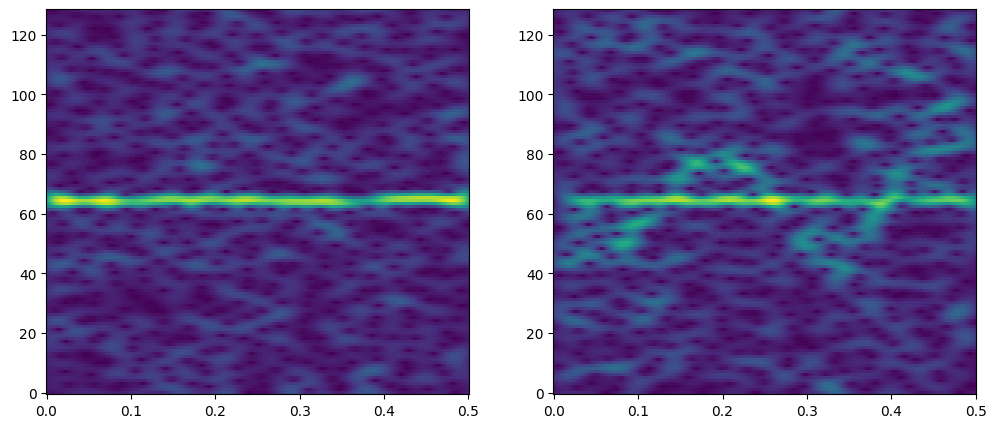

In [29]:
x,y = train_dataset.__getitem__(0)
print(f'label is {y}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,128,128), x[0,:,:]);
axes[1].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,128,128), x[1,:,:]);

print(np.stack((x[0],x[1]), axis=0).shape)

# Extract feature from m-D

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 16 * 64, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 64)
        x = x.view(x.size(0), -1)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# # 参数设置
num_classes  = 4  # 类别数
model = CNN(num_classes)
num_epochs = 200
learning_rate = 0.001

# # 初始化模型、损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
model.to(device)

def transfer_device(x,y):
    # Move inputs and labels to the device if they are not already
    if x.device != device:
        x = x.to(device)
    if y.device != device:
        y = y.to(device)
    return x,y

def tensor_process(x, y):
    x, y = transfer_device(x, y) # only use tfr.
    return x, y 

for x,y in train_loader:
    x,y = tensor_process(x, y)
    print(x.shape, y.shape)
    y = model(x)
    print(y.shape)
    break

torch.Size([32, 2, 128, 512]) torch.Size([32])
torch.Size([32, 4])


In [8]:
model.to(device)

def train(dataloader, loss_fn, optimizer):
    total_acc, total_count, total_loss, = 0, 0, 0
    model.train()
    for x, y in dataloader:
        x, label = tensor_process(x, y)
        predicted_label = model(x)
        loss = loss_fn(predicted_label, label)
        # Back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_acc += (predicted_label.argmax(1) == label).sum().item()  # predict true
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def test(dataloader, loss_fn):
    model.eval()
    total_acc, total_count, total_loss, = 0, 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, label = tensor_process(x, y)
            predicted_label = model(x)
            loss = loss_fn(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def fit(epochs, train_dl, test_dl, loss_fn, optimizer):
    train_loss = [] 
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = train(train_dl, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, loss_fn)

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        tqdm.write(f'epoch:{epoch}, train_loss:{epoch_loss}, train_acc:{epoch_acc*100}%, test_loss:{epoch_test_loss}, test_acc:{epoch_test_acc*100}%.')
    
    return train_loss, test_loss, train_acc, test_acc

In [9]:
EPOCHS = 20
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, criterion, optimizer)

'''0db: 我真觉得交叉极化下的数据本身就会被淹没在热噪声之中。
epoch:0, train_loss:0.8704690172672271, train_acc:60.875%, test_loss:0.5696358889341354, test_acc:77.0%.
epoch:1, train_loss:0.24818401415646077, train_acc:91.325%, test_loss:0.3186625598371029, test_acc:87.8125%.
epoch:2, train_loss:0.12477992078661919, train_acc:95.35%, test_loss:0.28417732268571855, test_acc:90.0%.
epoch:3, train_loss:0.09814680800586939, train_acc:96.65%, test_loss:0.188712889701128, test_acc:93.1875%.
epoch:4, train_loss:0.06464273007214069, train_acc:97.775%, test_loss:0.14639618311077357, test_acc:95.25%.
epoch:5, train_loss:0.05228634131513536, train_acc:98.45%, test_loss:0.24690151466056703, test_acc:91.875%.
epoch:6, train_loss:0.04352297049667686, train_acc:98.45%, test_loss:0.11289237347315066, test_acc:96.4375%.
epoch:7, train_loss:0.038036757109919564, train_acc:98.675%, test_loss:0.1603587621776387, test_acc:94.625%.
epoch:8, train_loss:0.032854747418197806, train_acc:98.875%, test_loss:0.13624728740658612, test_acc:95.5%.
epoch:9, train_loss:0.027534942921018227, train_acc:99.05000000000001%, test_loss:0.12926782739930787, test_acc:96.0625%.
epoch:10, train_loss:0.03406277799769305, train_acc:98.925%, test_loss:0.2051552761811763, test_acc:94.6875%.
epoch:11, train_loss:0.02240345870173769, train_acc:99.225%, test_loss:0.1618308903183788, test_acc:95.8125%.
epoch:12, train_loss:0.01572134095814545, train_acc:99.52499999999999%, test_loss:0.12406453705130843, test_acc:96.8125%.
epoch:13, train_loss:0.0153691918682307, train_acc:99.5%, test_loss:0.15398993602371774, test_acc:96.3125%.
epoch:14, train_loss:0.04133186918718275, train_acc:98.5%, test_loss:0.10486592508968898, test_acc:96.625%.
epoch:15, train_loss:0.018923399338222225, train_acc:99.4%, test_loss:0.127652688702874, test_acc:97.1875%.
epoch:16, train_loss:0.005148113633709727, train_acc:99.875%, test_loss:0.16537371459649874, test_acc:95.9375%.
epoch:17, train_loss:0.023091654436211684, train_acc:99.45%, test_loss:0.2696311264298856, test_acc:94.4375%.
epoch:18, train_loss:0.03011075249686837, train_acc:99.1%, test_loss:0.11554747080197558, test_acc:96.6875%.
epoch:19, train_loss:0.01169275787618244, train_acc:99.625%, test_loss:0.09965696335479152, test_acc:97.8125%.
'''

epoch:0, train_loss:1.0193326704502106, train_acc:53.025%, test_loss:0.6607704275846481, test_acc:67.0625%.
epoch:1, train_loss:0.34626446330547334, train_acc:87.075%, test_loss:0.255079143345356, test_acc:90.75%.
epoch:2, train_loss:0.1389790660440922, train_acc:95.325%, test_loss:0.18324204765260219, test_acc:93.625%.
epoch:3, train_loss:0.12522018568962812, train_acc:95.65%, test_loss:0.15554262522608042, test_acc:94.375%.
epoch:4, train_loss:0.08491335202101619, train_acc:97.15%, test_loss:0.15771791640669108, test_acc:94.0625%.
epoch:5, train_loss:0.056309670373797416, train_acc:98.0%, test_loss:0.16776510117575527, test_acc:94.75%.
epoch:6, train_loss:0.048679968647658826, train_acc:98.2%, test_loss:0.14503815210424365, test_acc:95.4375%.
epoch:7, train_loss:0.03211890508746728, train_acc:98.9%, test_loss:0.12972779057919978, test_acc:96.5625%.
epoch:8, train_loss:0.04287819106900133, train_acc:98.5%, test_loss:0.1490998209454119, test_acc:95.0625%.
epoch:9, train_loss:0.02666219

'0db: 我真觉得交叉极化下的数据本身就会被淹没在热噪声之中。\nepoch:0, train_loss:0.8704690172672271, train_acc:60.875%, test_loss:0.5696358889341354, test_acc:77.0%.\nepoch:1, train_loss:0.24818401415646077, train_acc:91.325%, test_loss:0.3186625598371029, test_acc:87.8125%.\nepoch:2, train_loss:0.12477992078661919, train_acc:95.35%, test_loss:0.28417732268571855, test_acc:90.0%.\nepoch:3, train_loss:0.09814680800586939, train_acc:96.65%, test_loss:0.188712889701128, test_acc:93.1875%.\nepoch:4, train_loss:0.06464273007214069, train_acc:97.775%, test_loss:0.14639618311077357, test_acc:95.25%.\nepoch:5, train_loss:0.05228634131513536, train_acc:98.45%, test_loss:0.24690151466056703, test_acc:91.875%.\nepoch:6, train_loss:0.04352297049667686, train_acc:98.45%, test_loss:0.11289237347315066, test_acc:96.4375%.\nepoch:7, train_loss:0.038036757109919564, train_acc:98.675%, test_loss:0.1603587621776387, test_acc:94.625%.\nepoch:8, train_loss:0.032854747418197806, train_acc:98.875%, test_loss:0.13624728740658612, test_

In [12]:
# torch.save(model, 'model(HHVHTFR).pth')
# load model
model = torch.load('model(HHVHTFR).pth')
model.eval()  # 设置模型为评估模式

CNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

# Fusion with hrrp

In [61]:
# def data processing here.
def preprocessing(data, snr, pad_size):
    polar_type = ['HH', 'VH', 'HV']

    # extract hrrp
    hrrp0 = awgn(data['hrrp'][polar_type[0]], snr=snr)
    hrrp0 = image_hrrp(hrrp0, pad_size = pad_size)

    hrrp1 = awgn(data['hrrp'][polar_type[1]], snr=snr)
    hrrp1 = image_hrrp(hrrp1, pad_size = pad_size)

    hrrp2 = awgn(data['hrrp'][polar_type[2]], snr=snr)
    hrrp2 = image_hrrp(hrrp2, pad_size = pad_size)
       
    return np.stack((hrrp0,hrrp1,hrrp2), axis=0)[:,75:125,:]
    # return rcs_data

class Dataset(Dataset):
    def __init__(self, dataset_dir, snr, pad_size):
        self.snr = snr
        self.pad_size = pad_size
        self.dataset_dir = dataset_dir
        self.instance_list = self.get_instance()
    
    def get_instance(self):
        instance_list = []
        for label in os.listdir(self.dataset_dir):
            label_dir = os.path.join(self.dataset_dir,label)
            label_list = glob.glob(label_dir+'/*.pkl')
            instance_list += label_list
        return instance_list

    def __len__(self):
        return len(self.instance_list)

    def __getitem__(self, idx):
        data = load_pkl(self.instance_list[idx])
        x = preprocessing(data, snr = self.snr, pad_size= self.pad_size)
        y = data['target_id']
        # return torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


In [78]:
snr = 0
pad_size = None
train_dataset = Dataset(train_data_path, snr = snr, pad_size = pad_size)
test_dataset = Dataset(test_data_path, snr = snr, pad_size = pad_size)

label is 2
torch.Size([3, 50, 512])


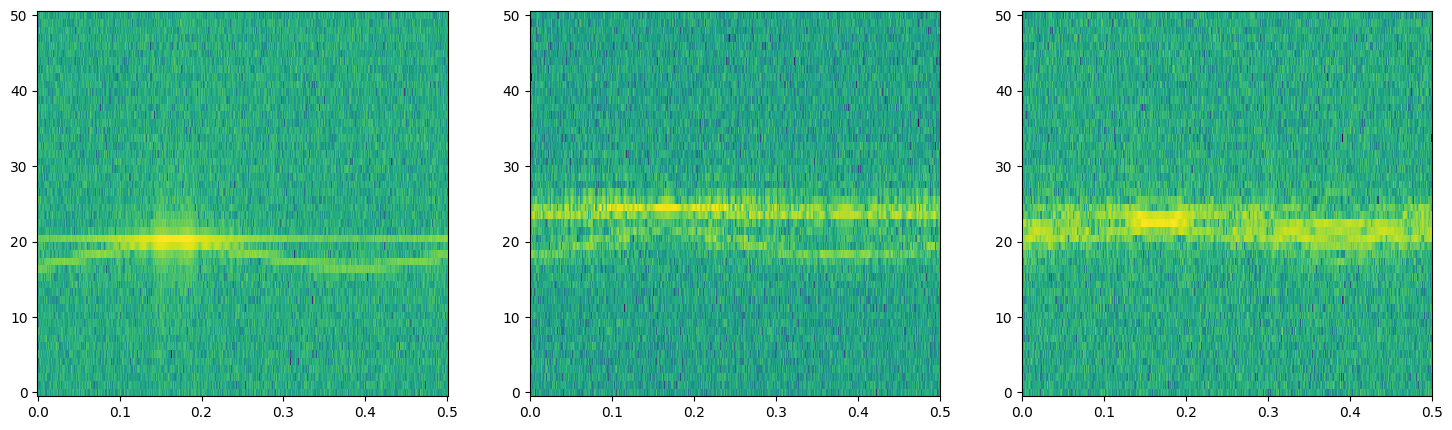

In [79]:
x,y = train_dataset.__getitem__(3001)
print(f'label is {y}')
print(x.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,50,50), x[0,:,:]);
axes[1].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,50,50), x[1,:,:]);
axes[2].pcolormesh(np.linspace(0,0.5,512), np.linspace(0,50,50), x[2,:,:]);
# for ax in axes:
#     ax.set_ylim([75,125])



In [80]:
class HRRPCNN(nn.Module):
    def __init__(self, num_classes):
        super(HRRPCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 6 * 64, 128)  # assuming input image size is 3x50x512
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 64)  # 展平张量
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# # 参数设置
num_classes  = 4  # 类别数
model = HRRPCNN(num_classes)
learning_rate = 0.001

# # 初始化模型、损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [81]:
model.to(device)

def transfer_device(x,y):
    # Move inputs and labels to the device if they are not already
    if x.device != device:
        x = x.to(device)
    if y.device != device:
        y = y.to(device)
    return x,y

def tensor_process(x, y):
    x, y = transfer_device(x, y) 
    return x, y 

for x,y in train_loader:
    x,y = tensor_process(x, y)
    print(x.shape, y.shape)
    y = model(x)
    print(y.shape)
    break

torch.Size([32, 3, 50, 512]) torch.Size([32])
torch.Size([32, 4])


In [82]:
EPOCHS = 20
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, criterion, optimizer)
'''20db 75:125
epoch:0, train_loss:1.307599841594696, train_acc:35.0%, test_loss:0.8086566603183747, test_acc:68.9375%.
epoch:1, train_loss:0.5327327561378479, train_acc:79.5%, test_loss:0.322849962413311, test_acc:86.0625%.
epoch:2, train_loss:0.19722731760144233, train_acc:93.4%, test_loss:0.07651738768443465, test_acc:97.5625%.
epoch:3, train_loss:0.09729826283827424, train_acc:96.65%, test_loss:0.13336956236511469, test_acc:96.0%.
epoch:4, train_loss:0.05256426967680454, train_acc:98.3%, test_loss:0.04674869796494022, test_acc:98.625%.
epoch:5, train_loss:0.018228161965031176, train_acc:99.375%, test_loss:0.017508560669375582, test_acc:99.5625%.
epoch:6, train_loss:0.04256997250113636, train_acc:98.32499999999999%, test_loss:0.029729730570688843, test_acc:99.0625%.
epoch:7, train_loss:0.013984536267700605, train_acc:99.65%, test_loss:0.010767727159545756, test_acc:99.625%.
epoch:8, train_loss:0.011366839628724847, train_acc:99.675%, test_loss:0.02272743169683963, test_acc:99.25%.
epoch:9, train_loss:0.002753057197900489, train_acc:99.97500000000001%, test_loss:0.0077525663832784635, test_acc:99.875%.
epoch:10, train_loss:0.05377999444465968, train_acc:98.225%, test_loss:0.08397555899806321, test_acc:96.5%.
'''

'''0db 75:125
epoch:0, train_loss:1.3887404022216796, train_acc:27.650000000000002%, test_loss:1.3734530806541443, test_acc:31.5625%.
epoch:1, train_loss:1.2888042778968811, train_acc:40.125%, test_loss:0.8477758872509003, test_acc:65.1875%.
epoch:2, train_loss:0.6357867500782013, train_acc:72.85000000000001%, test_loss:0.2898388010263443, test_acc:90.875%.
epoch:3, train_loss:0.17816923889517783, train_acc:93.675%, test_loss:0.07135210365056992, test_acc:98.125%.
epoch:4, train_loss:0.04355977649241686, train_acc:98.825%, test_loss:0.024484881227836014, test_acc:99.4375%.
epoch:5, train_loss:0.017223093373235316, train_acc:99.575%, test_loss:0.014158367938362061, test_acc:99.5625%.
epoch:6, train_loss:0.015037457248661667, train_acc:99.575%, test_loss:0.02926013361895457, test_acc:98.875%.
epoch:7, train_loss:0.0333407127163373, train_acc:98.825%, test_loss:0.02622553407214582, test_acc:99.125%.
epoch:8, train_loss:0.0031745620163273996, train_acc:99.97500000000001%, test_loss:0.0054870520206168295, test_acc:99.875%.
epoch:9, train_loss:0.0039554039465147075, train_acc:99.95%, test_loss:0.025441354122012854, test_acc:99.1875%.
epoch:10, train_loss:0.004863941651943605, train_acc:99.875%, test_loss:0.0029783972915902266, test_acc:99.875%.
epoch:11, train_loss:0.000567443931257003, train_acc:100.0%, test_loss:0.0022391418150800747, test_acc:100.0%.
epoch:12, train_loss:0.02377805736323353, train_acc:99.4%, test_loss:0.02417788260150701, test_acc:99.125%.
epoch:13, train_loss:0.006345452062028926, train_acc:99.8%, test_loss:0.03161294318269938, test_acc:98.9375%.
epoch:14, train_loss:0.007326915839628782, train_acc:99.8%, test_loss:0.003510572447703453, test_acc:99.875%.
epoch:15, train_loss:0.00041248695875401606, train_acc:100.0%, test_loss:0.0008968500022456283, test_acc:100.0%.
epoch:16, train_loss:0.0002454829701673589, train_acc:100.0%, test_loss:0.000780701000985573, test_acc:100.0%.
epoch:17, train_loss:0.004392309941373242, train_acc:99.9%, test_loss:0.19476956125348807, test_acc:93.9375%.
epoch:18, train_loss:0.017125080077326858, train_acc:99.425%, test_loss:0.012372074951417743, test_acc:99.625%.
epoch:19, train_loss:0.005212945462641073, train_acc:99.825%, test_loss:0.006165183320190408, test_acc:99.75%.
'''

epoch:0, train_loss:1.3887404022216796, train_acc:27.650000000000002%, test_loss:1.3734530806541443, test_acc:31.5625%.
epoch:1, train_loss:1.2888042778968811, train_acc:40.125%, test_loss:0.8477758872509003, test_acc:65.1875%.
epoch:2, train_loss:0.6357867500782013, train_acc:72.85000000000001%, test_loss:0.2898388010263443, test_acc:90.875%.
epoch:3, train_loss:0.17816923889517783, train_acc:93.675%, test_loss:0.07135210365056992, test_acc:98.125%.
epoch:4, train_loss:0.04355977649241686, train_acc:98.825%, test_loss:0.024484881227836014, test_acc:99.4375%.
epoch:5, train_loss:0.017223093373235316, train_acc:99.575%, test_loss:0.014158367938362061, test_acc:99.5625%.
epoch:6, train_loss:0.015037457248661667, train_acc:99.575%, test_loss:0.02926013361895457, test_acc:98.875%.
epoch:7, train_loss:0.0333407127163373, train_acc:98.825%, test_loss:0.02622553407214582, test_acc:99.125%.
epoch:8, train_loss:0.0031745620163273996, train_acc:99.97500000000001%, test_loss:0.0054870520206168295

'20db 75:125\nepoch:0, train_loss:1.307599841594696, train_acc:35.0%, test_loss:0.8086566603183747, test_acc:68.9375%.\nepoch:1, train_loss:0.5327327561378479, train_acc:79.5%, test_loss:0.322849962413311, test_acc:86.0625%.\nepoch:2, train_loss:0.19722731760144233, train_acc:93.4%, test_loss:0.07651738768443465, test_acc:97.5625%.\nepoch:3, train_loss:0.09729826283827424, train_acc:96.65%, test_loss:0.13336956236511469, test_acc:96.0%.\nepoch:4, train_loss:0.05256426967680454, train_acc:98.3%, test_loss:0.04674869796494022, test_acc:98.625%.\nepoch:5, train_loss:0.018228161965031176, train_acc:99.375%, test_loss:0.017508560669375582, test_acc:99.5625%.\nepoch:6, train_loss:0.04256997250113636, train_acc:98.32499999999999%, test_loss:0.029729730570688843, test_acc:99.0625%.\nepoch:7, train_loss:0.013984536267700605, train_acc:99.65%, test_loss:0.010767727159545756, test_acc:99.625%.\nepoch:8, train_loss:0.011366839628724847, train_acc:99.675%, test_loss:0.02272743169683963, test_acc:99

In [84]:
# torch.save(model, 'model(HHVHHVHRRP).pth')
# # load model
model = torch.load('model(HHVHHVHRRP).pth')
model.eval()  # 设置模型为评估模式

HRRPCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=49152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='predicting...'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

predicting...: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


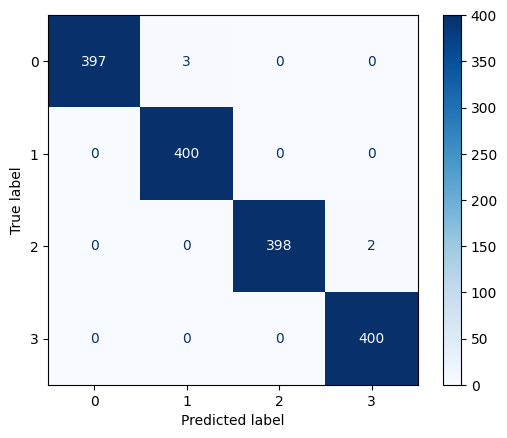

In [89]:
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.show()